In [57]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr

In [58]:
# The function below draws a correlation matrix.

In [93]:
def draw_corr(plot_df, show_annotations=True):
    # Preparing the correlation matrix
    corr = plot_df.corr(numeric_only=True)
    # Calculating the p-values
    pval = (plot_df.corr(
        numeric_only=True,
        method=lambda x, y: pearsonr(x, y)[1]) - np.eye(*corr.shape))
    # Preparing a table of correlations and p-values together
    corr_pval = corr.round(2).astype(str) + '\n(' + pval.round(3).astype(str) + ')'

    # Plotting the correlation matrix and annotating it with the generated table
    plt.figure(figsize=(15,15))
    hm = sns.heatmap(data=corr, 
                    annot=corr_pval if show_annotations else None,
                    fmt = '', 
                    cmap='RdBu_r',
                    mask=np.triu(corr))

# Loading the dataset

In [60]:
df = pd.read_csv("./dataset/matches_initial.csv", parse_dates=['date'])

df

,season,date,home,away,home_fulltime_goals,away_fulltime_goals,fulltime_result,home_halftime_goals,away_halftime_goals,halftime_result,...,home_fouls_committed,away_fouls_committed,home_fouls_won,away_fouls_won,home_yellow_cards,away_yellow_cards,home_red_cards,away_red_cards,home_xg,away_xg
0,2017_2018,2017-08-18,Leganes,Alaves,1,0,H,1,0,H,...,17,17,16,17,0,1,0,0,1.3,1.1
1,2017_2018,2017-08-18,Valencia,Las Palmas,1,0,H,1,0,H,...,25,13,13,24,3,2,0,1,1.4,0.2
2,2017_2018,2017-08-19,Celta Vigo,Real Sociedad,2,3,A,1,1,D,...,12,11,10,11,3,1,0,0,1.8,2.1
3,2017_2018,2017-08-19,Girona,Atletico Madrid,2,2,D,2,0,H,...,15,15,14,15,2,4,0,1,2.2,0.7
4,2017_2018,2017-08-19,Sevilla,Espanyol,1,1,D,1,1,D,...,14,12,12,14,2,4,1,0,2.4,1.3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2117,2022_2023,2023-02-26,Athletic Bilbao,Girona,2,3,A,1,3,A,...,17,8,7,17,5,5,0,0,1.6,1.2
2118,2022_2023,2023-02-26,Celta Vigo,Real Valladolid,3,0,H,2,0,H,...,6,5,4,6,1,3,0,1,1.8,0.5
2119,2022_2023,2023-02-26,Almeria,Barcelona,1,0,H,1,0,H,...,13,11,11,13,3,3,0,0,1.0,1.1
2120,2022_2023,2023-02-26,Sevilla,Osasuna,2,3,A,0,1,A,...,10,15,15,9,4,2,1,0,2.2,1.0


# Dealing with missing values

The following features contain missing values:

In [61]:
isna_sum = df.isna().sum()
isna_features = isna_sum[isna_sum > 0]

isna_features

home_win_pinnaclesports_odds              3
draw_pinnaclesports_odds                  3
away_win_pinnaclesports_odds              3
home_win_pinnaclesports_closing_odds      1
draw_pinnaclesports_closing_odds          1
away_win_pinnaclesports_closing_odds      1
attendance                              487
dtype: int64

'attendance' (the total number of people attending the venue to watch the match) contains too many missing values and since it cannot be deducted from other features, the best strategy is to drop this feature.

In [62]:
df = df.drop('attendance', axis='columns')

As for the other columns including missing values, since the total number of instances are too few, those instances can safely be dropped.

In [63]:
df = df.dropna(axis='index')

# Preparing the data model

In order to create a panel data model, two component are required:
<ul>
<li>The time component</li>
<li>The cross-sectional component</li>
</ul>

The time component is the date feature of each match; as for the cross-sectional component, each team comprises one section. Hence, the match data will be melted and the data of all the teams will be stacked under each other (rather than next to each other in home/away columns).

## Melt/stack the data

The cell below transforms the dataframe to store all teams stacked under each other (regardless of home/away attributes).

In [64]:
def get_stacked_df(orig_df):
    # Saving the team names temporarily
    orig_df[['temp_home', 'temp_away']] = orig_df[['home', 'away']]

    # All the current columns within the input dataframe
    all_cols = set(orig_df.columns)
    # The Columns to melt
    melting_value_cols = {'home', 'away'}
    # The ID columns to repeat for each melted value
    melting_id_cols = all_cols - melting_value_cols
    # The suffix of the team-specific columns (the column name without the home/away prefix)
    col_suffixes = [col[5:] for col in orig_df.columns if 'away_' in col]
    # Columns related to 'team_1'
    home_cols = [f"home_{col}" for col in col_suffixes]
    # Columns related to 'team_2'
    away_cols = [f"away_{col}" for col in col_suffixes]

    # Putting the melting columns' values into a new column named 'team'
    # Adding a new column 'ground' denoting whether the melted column
    # was home or away
    res = orig_df.melt(
        id_vars=melting_id_cols,
        value_vars=melting_value_cols,
        var_name='ground',
        value_name='team'
    )

    # Setting the opponent's name
    res['opponent'] = res.apply(
        lambda row: row['temp_home'] if row['ground'] == 'away' else row['temp_away'],
        axis='columns'
    )

    # If the melted column was home, add the home related scores into
    # a set of general score columns prefixed by 'own_'; otherwise, add
    # the away related scores.
    res[[f"team_{col}" for col in col_suffixes]] = res.apply(
        lambda row: pd.Series(
            [row[col] for col in home_cols]
            if row['ground'] == 'home' else
            [row[col] for col in away_cols]),
        axis='columns'
    )
    # In either case, add the opponent's attributes into columns suffixed by 'opponent_'
    res[[f"opponent_{col}" for col in col_suffixes]] = res.apply(
        lambda row: pd.Series(
            [row[col] for col in home_cols]
            if row['ground'] == 'away' else
            [row[col] for col in away_cols]),
        axis='columns'
    )

    # Drop the redundant columns (home/away attributes)
    cols_to_drop = home_cols + away_cols + ['temp_home', 'temp_away']
    res = res.drop(cols_to_drop, axis='columns')

    # Returning the newly generated dataframe as output
    return res

df = get_stacked_df(df)

# Converting post-game data to pre-game and computing the First Differance
Currently apart from betting odds, xg and the rating, the rest of the attributes (fouls, goals, passes, ...) are calculated after the game; and since the target of the study is to predict the result of a game that has not happenned yet, only the pre-game metrics and predictors may be used; hence, the post-match data should be replaced with pre-match data.
In that sense, the meaning of the variable 'yellow_cards' will be the total number of the yellow cards the team received within the match preceding the current one.
Since this operation comprises looping over the whole dataset, it is very resource intensive and time consuming; hence, it was decided to embed another data pre-processing step in this loop as well, which is to compute the first differance.

In [65]:
# Sorting the data and creating a refrence dataframe
df_ref = df.sort_values(['season', 'team', 'date']).copy(deep=True)

# Preparing the column lists
col_suffixes = [col[5:] for col in df.columns if (
    (col[:5] == 'team_') and (all(term not in col for term in ['xg', 'rating', 'prob']))
)]
fd_col_suffixes = [col[5:] for col in df.columns if (col[:5] == 'team_')]

ref_cols = [f"team_{col_suffix}" for col_suffix in col_suffixes]
ref_team_fd_cols = [f"team_{col_suffix}" for col_suffix in fd_col_suffixes]
ref_draw_fd_cols = [col for col in df.columns if (col[:5] == 'draw_')]
team_cols = [f"team_{col_suffix}" for col_suffix in col_suffixes]
team_fd_cols = [f"fd_team_{col_suffix}" for col_suffix in fd_col_suffixes]
opponent_cols = [f"opponent_{col_suffix}" for col_suffix in col_suffixes]
opponent_fd_cols = [f"fd_opponent_{col_suffix}" for col_suffix in fd_col_suffixes]
draw_fd_cols = [f"fd_{col}" for col in df.columns if (col[:5] == 'draw_')]

# receives the team name, and returns the first diff of the last two observations before the given date
def get_last_attributes(match_season, match_date, match_team, include_draw=False):
    # Filtering the ref dataframe for team
    filter = ((df_ref['season'] == match_season) &
                (df_ref['date'] < match_date) &
                (df_ref['team'] == match_team))
    df_ref_filtered = df_ref[filter][ref_cols]
    if include_draw:
        df_ref_filtered_fd = df_ref[filter][ref_team_fd_cols + ref_draw_fd_cols].diff(axis='index')
    else:
        df_ref_filtered_fd = df_ref[filter][ref_team_fd_cols].diff(axis='index')
    
    # if it was the team's first two matches of the season, returns None, otherwise returns the first diff
    return (None if (df_ref_filtered.empty or df_ref_filtered_fd.empty) 
            else (list(df_ref_filtered.iloc[-1]) + list(df_ref_filtered_fd.iloc[-1])))

# Going over each row in the dataset
for index, row in df.iterrows():
    cur_season = row['season']
    cur_date = row['date']
    cur_team = row['team']
    cur_opponent = row['opponent']
    
    # Retrieving the team's most recent attributes
    df.loc[index, team_cols + team_fd_cols + draw_fd_cols] = get_last_attributes(cur_season, cur_date, cur_team, include_draw=True)
    
    # Retrieving the opponent's most recent attributes
    df.loc[index, opponent_cols + opponent_fd_cols] = get_last_attributes(cur_season, cur_date, cur_opponent)

# Dropping each team's first two matches of the season (where the pre-match data is None)
df = df.dropna()

# Dropping redundant features

In this step, the primary features will be reviewed and the redundant ones will be dropped.

## Betting odds

The betting odds are gathered from several sources, some of which might correlate very closely; hence, they are analyzed and a candidate subset is selected.

In [86]:
betting_cols = [col 
                for term in ['team_win_', 'draw_', 'opponent_win_'] 
                for col in df.columns if term in col]

betting_cols

['team_win_bet365_odds',
 'fd_team_win_bet365_odds',
 'draw_bet365_odds',
 'fd_draw_bet365_odds',
 'opponent_win_bet365_odds',
 'fd_opponent_win_bet365_odds']

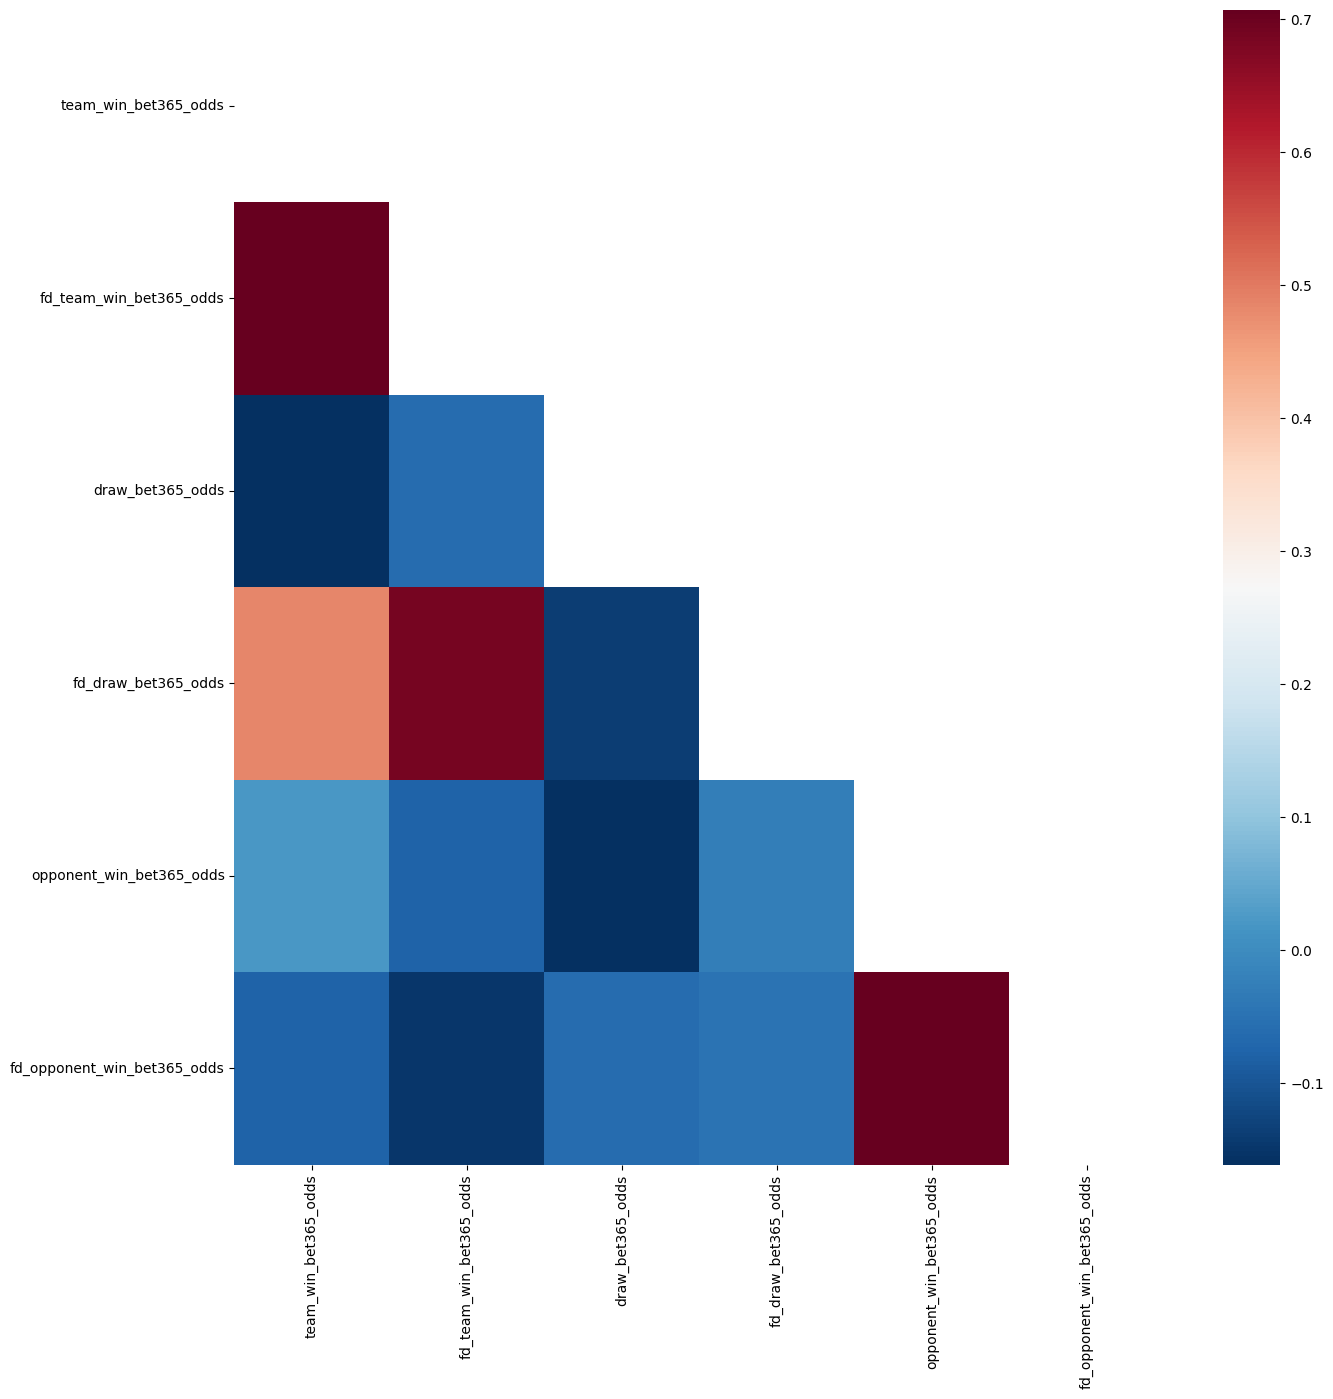

In [96]:
draw_corr(df[betting_cols], show_annotations=False)

As can be seen, each group of betting odds (own_win, draw, and opponent) of every source closely correlates with the same group of every other source; so, taking only one of the sources makes sense as well as simplifies the model.<br>
The data gathered from bet365 will be kept and the rest will be dropped.

In [85]:
df = df.drop([col for col in betting_cols if 'bet365' not in col], axis='columns')

## Ratings

currently there are three rating features for each of the home and away teams:
<ul>
<li>pre_rating</li>
<li>rating_delta</li>
<li>post_rating</li>
</ul>

In [34]:
rating_cols = [col for col in df.columns if 'rating' in col]

rating_cols

['own_pre_rating',
 'own_rating_delta',
 'own_post_rating',
 'opponent_pre_rating',
 'opponent_rating_delta',
 'opponent_post_rating']

Since the prediction we are about to achieve is based on pre-match attributes, only the pre-rating variable should be saved and the other two may be dropped.

In [35]:
df = df.drop(
    [col for col in rating_cols if 'pre' not in col],
    axis='columns'
)

## String features

In [36]:
df.select_dtypes('object').dtypes

season             object
halftime_result    object
fulltime_result    object
venue              object
ground             object
team               object
dtype: object

String features include the name of the team as well as the name of the venue where the match was taking place, the fulltime and halftime results, the matches' season, and the ground in which the team was playing (home or away).<br>
In order to use these in the prediction process, they need to be converted into categorical variables and encoded using ordinal or one-hot encoding; however, except for the 'ground' feature, the other sets of features are not closed (new categories might be added in the future) the training can never contain every possible value; hence, these features cannot be used in the model and should be dropped.<br>
The 'team' and 'season' features will be used for the panel data analysis and will be dropped after that, the 'ground' and result features will be encoded, and the 'venue' feature will be dropped right away.

In [37]:
df = df.drop('venue', axis='columns')

# Feature type casting

## Encoding the categorical

The categorical features include the results (halftime and fulltime) and the ground (home/away)

In [38]:
df['halftime_result'].value_counts()

D    1900
H    1356
A     980
Name: halftime_result, dtype: int64

In [39]:
df['fulltime_result'].value_counts()

H    1882
A    1208
D    1146
Name: fulltime_result, dtype: int64

In [40]:
def encode_result(ground, result):
    if result == 'D':
        return 1
    elif ((result == 'H' and ground == 'home') or (result == 'A' and ground == 'away')):
        return 2
    else:
        return 0

for col in ['halftime_result', 'fulltime_result']:
    df[col] = df.apply(
        lambda row: encode_result(row['ground'], row[col]),
        axis='columns'
    )

In [41]:
df['ground'] = df['ground'].replace(
    to_replace={
        'away': '0',
        'home': '1',
    }
)

## Converting post-game data to pre-game

Currently apart from betting odds, xg and the rating, the rest of the attributes (fouls, goals, passes, ...) are calculated after the game; and since the target of the study is to predict the result of a game that has not happenned yet, only the pre-game metrics and predictors may be used; hence, the post-match data should be replaced with pre-match data.<br>
In that sense, the meaning of the variable 'yellow_cards' will be the total number of the yellow cards the team received within the match preceding the current one.

In [42]:
# TODO: Perform this step: 1. sort by season/team/date 2. bfill/ffill? 3. delete the teams' first match in every season

In [48]:
df.shape

(4236, 49)

In [50]:
# Generating the list of columns that need refactoring
cols = [col for col in df.columns if (
    any(term in col for term in ['own', 'opponent']) and
    all(term not in col for term in ['xg', 'rating', 'prob'])
    )]

df = df.sort_values(['season', 'team', 'date'])
sorted_df = df.sort_values(['season', 'team', 'date'])
sorted_df[cols] = sorted_df[cols].shift(1)
sorted_df = sorted_df.dropna(axis='index')

# Making the observation intervals homogeneous

In [50]:
# Extracting the list of seasons as well as the start date of each one
season_start_dates = dict()
for season, matches in df.groupby('season'):
    season_start_dates[season] = matches.sort_values('date', ascending=True).iloc[0]['date']
    
df['season_week_no'] = df.apply(
    lambda row: (row['date'] - season_start_dates[row['season']]).days // 7,
    axis='columns'
)

# Duplicate instances

In [51]:
df[df.duplicated()]

,season,date,home,away,home_fulltime_goals,away_fulltime_goals,fulltime_result,home_halftime_goals,away_halftime_goals,halftime_result,...,home_yellow_cards,away_yellow_cards,home_red_cards,away_red_cards,home_xg,away_xg,home_win_prob,draw_prob,away_win_prob,season_week_no


There are no fully duplicated instances in the dataframe.

In [52]:
not_dup_cols = ['season', 'date', 'home', 'away', 'fulltime_home_goals', 'fulltime_away_goals', 'fulltime_result', 'halftime_result', 'venue']

df[df.duplicated(subset=[col for col in df.columns if col not in not_dup_cols])]

,season,date,home,away,home_fulltime_goals,away_fulltime_goals,fulltime_result,home_halftime_goals,away_halftime_goals,halftime_result,...,home_yellow_cards,away_yellow_cards,home_red_cards,away_red_cards,home_xg,away_xg,home_win_prob,draw_prob,away_win_prob,season_week_no


There are also no duplicate instances where any two teams with the same attributes go against each other, regardless of the game result and number of scored goals.

# Outlier identification

In [53]:
from IPython.display import display
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(df.describe()) 

,home_fulltime_goals,away_fulltime_goals,fulltime_result,home_halftime_goals,away_halftime_goals,halftime_result,home_pre_rating,away_pre_rating,home_possession,away_possession,home_total_shots,away_total_shots,home_shots_on_target,away_shots_on_target,home_shots_off_target,away_shots_off_target,home_blocked,away_blocked,home_passing_percent,away_passing_percent,home_clear_cut_chances,away_clear_cut_chances,home_corners,away_corners,home_offsides,away_offsides,home_tackles_percent,away_tackles_percent,home_aerial_duels,away_aerial_duels,home_saves,away_saves,home_fouls_committed,away_fouls_committed,home_fouls_won,away_fouls_won,home_yellow_cards,away_yellow_cards,home_red_cards,away_red_cards,home_xg,away_xg,home_win_prob,draw_prob,away_win_prob,season_week_no
count,2055.000000,2055.000000,2055.000000,2055.000000,2055.000000,2055.000000,2055.000000,2055.000000,2055.000000,2055.000000,2055.000000,2055.000000,2055.000000,2055.000000,2055.000000,2055.000000,2055.000000,2055.000000,2055.000000,2055.000000,2055.000000,2055.000000,2055.000000,2055.000000,2055.000000,2055.000000,2055.000000,2055.000000,2055.000000,2055.000000,2055.00000,2055.000000,2055.000000,2055.000000,2055.000000,2055.000000,2055.000000,2055.000000,2055.000000,2055.000000,2055.000000,2055.000000,2055.000000,2055.000000,2055.000000,2055.000000
mean,1.149392,1.388808,1.163504,0.507056,0.596594,1.089538,1986.682238,1986.202920,48.597567,50.513382,10.689051,12.639903,3.684185,4.380049,4.430657,5.314355,2.574209,2.945499,76.643796,77.945985,1.297810,1.524088,4.352311,5.062774,2.174696,2.224331,61.037470,60.791727,49.086618,50.077372,3.00146,2.527981,13.571290,13.496350,12.854501,12.679319,2.480292,2.340146,0.117275,0.119221,1.447786,1.106375,0.259533,0.356019,0.384545,19.497324
std,1.118826,1.226600,0.839351,0.732354,0.784643,0.738272,130.853772,131.072154,11.592232,11.529045,4.388747,4.857739,2.152198,2.449508,2.451463,2.697047,1.933716,2.080874,8.670009,7.911604,1.292202,1.381573,2.561125,2.753497,1.805850,1.717313,13.880876,13.798079,10.677274,10.668564,1.96327,1.758017,4.104247,4.136411,4.013457,4.039223,1.475696,1.465813,0.336614,0.348729,0.800039,0.700107,0.132028,0.028928,0.142842,12.228865
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1754.000000,1757.000000,17.000000,17.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,41.000000,45.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,14.000000,0.000000,0.000000,15.000000,0.00000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.100000,0.000000,0.020000,0.230000,0.050000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1891.000000,1891.000000,40.000000,43.000000,8.000000,9.000000,2.000000,3.000000,3.000000,3.000000,1.000000,1.000000,72.000000,73.000000,0.000000,0.000000,2.000000,3.000000,1.000000,1.000000,52.000000,52.000000,42.000000,43.000000,2.00000,1.000000,11.000000,11.000000,10.000000,10.000000,1.000000,1.000000,0.000000,0.000000,0.900000,0.600000,0.160000,0.340000,0.280000,9.000000
50%,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1957.000000,1958.000000,48.000000,51.000000,10.000000,12.000000,3.000000,4.000000,4.000000,5.000000,2.000000,3.000000,78.000000,79.000000,1.000000,1.000000,4.000000,5.000000,2.000000,2.000000,61.000000,61.000000,50.000000,50.000000,3.00000,2.000000,13.000000,13.000000,13.000000,12.000000,2.000000,2.000000,0.000000,0.000000,1.300000,1.000000,0.250000,0.360000,0.390000,19.000000
75%,2.000000,2.000000,2.000000,1.000000,1.000000,2.000000,2053.000000,2053.000000,57.000000,59.000000,13.000000,15.000000,5.000000,6.000000,6.000000,7.000000,4.000000,4.000000,83.000000,84.000000,2.000000,2.000000,6.000000,7.000000,3.000000,3.000000,70.000000,70.000000,56.000000,57.000000,4.00000,4.000000,16.000000,16.000000,15.000000,15.000000,3.000000,3.000000,0.000000,0.000000,1.900000,1.500000,0.340000,0.380000,0.490000,29.000000
max,6.000000,8.000000,2.000000,5.000000,4.000000,2.000000,2415.0

The code below uses z-score with the threshold of 3 to detect outliers. 

In [54]:
outlier_cols = df.select_dtypes(include=['int', 'float']).columns

outlier_indices = set()
for col in outlier_cols:
    col_mean = round(df[col].mean(), 2)
    col_std = round(df[col].std(), 2)
    threshold = 3
    col_filtered = df[((df[col] - col_mean) / col_std) > 3]
    
    total_outliers = col_filtered.shape[0]
    
    if total_outliers > 0:
        print(f"{col}\n{'-'*30}\nTotal number of outliers: {total_outliers}")
        print(f"Mean={col_mean}, Std={col_std}")
        print(f"Outlier values: {col_filtered[col].unique()}\n")
        outlier_indices = outlier_indices.union(set(col_filtered.index))

home_fulltime_goals
------------------------------
Total number of outliers: 22
Mean=1.15, Std=1.12
Outlier values: [6 5]

away_fulltime_goals
------------------------------
Total number of outliers: 11
Mean=1.39, Std=1.23
Outlier values: [6 7 8]

home_halftime_goals
------------------------------
Total number of outliers: 35
Mean=0.51, Std=0.73
Outlier values: [3 5 4]

away_halftime_goals
------------------------------
Total number of outliers: 53
Mean=0.6, Std=0.78
Outlier values: [3 4]

home_pre_rating
------------------------------
Total number of outliers: 5
Mean=1986.68, Std=130.85
Outlier values: [2415 2406 2403 2400 2392]

away_pre_rating
------------------------------
Total number of outliers: 4
Mean=1986.2, Std=131.07
Outlier values: [2397 2383 2401 2393]

home_total_shots
------------------------------
Total number of outliers: 11
Mean=10.69, Std=4.39
Outlier values: [28 24 29 32 27 25]

away_total_shots
------------------------------
Total number of outliers: 13
Mean=12.64,

The outlier report shows that the extreme values are not the result of statistical mistakes, neither are semantically irregular; but they are the result of natural variation in the data; hence, it was decided to keep and not drop them.

# Storing the cleaned dataset

In [55]:
df_melt = get_stacked_df(df)
df_melt.to_csv("./dataset/team_references.csv", index=False)

In [56]:
df.to_csv("./dataset/matches_cleaned.csv", index=False)